In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gene_transcript_go_api as gtga
from math import log2

In [2]:
human = gtga.parse_input("../data/human_input.tsv")
mouse = gtga.parse_input("../data/mouse_input.tsv")


In [3]:
human_pannzer = gtga.parse_pannzer_annotation("../data/human.nr_off.pc.out")

In [4]:
human_path = "../res/human.no_empty_transcript.intragene_isoform_diversity.data.tsv"
mouse_path = "../res/mouse.no_empty_transcript.intragene_isoform_diversity.data.tsv"

In [5]:
human_df = pd.read_csv(human_path, sep='\t')
mouse_df = pd.read_csv(mouse_path, sep='\t')

human_exp = human_df[human_df['Type'] == 'Expected']
human_df = human_df[human_df['Type'] == 'Observed']
mouse_df = mouse_df[mouse_df['Type'] == 'Observed']


In [6]:
print(len(human_df), ' genes')
print(len(human_df[human_df['Jaccard Index'] != 1]), ' genes where JI != 1')
print(len(human_df[human_df['Jaccard Index'] != 0]), ' genes where JI != 0')
print(sum(human_df[human_df['Jaccard Index'] != 0]['Jaccard Index']!=1), ' genes where JI != 0 and != 1')
print(f'including {len(human_df[human_df["Number of isoform"] == 1])} single isoform genes ')

17587  genes
8304  genes where JI != 1
17580  genes where JI != 0
8297  genes where JI != 0 and != 1
including 6241 single isoform genes 


In [7]:
print(len(mouse_df), ' genes')
print(len(mouse_df[mouse_df['Jaccard Index'] != 1]), ' genes where JI != 1')
print(len(mouse_df[mouse_df['Jaccard Index'] != 0]), ' genes where JI != 0')
print(sum(mouse_df[mouse_df['Jaccard Index'] != 0]['Jaccard Index']!=1), ' genes where JI != 0 and != 1')
print(f'including {len(mouse_df[mouse_df["Number of isoform"] == 1])} single isoform genes ')

18513  genes
5081  genes where JI != 1
18511  genes where JI != 0
5079  genes where JI != 0 and != 1
including 9980 single isoform genes 


## Orthologs

In [8]:
hs2semsim = pd.Series(human_df["BP similarity"].values, index=human_df['Gene']).to_dict()
mm2semsim = pd.Series(mouse_df["BP similarity"].values, index=mouse_df['Gene']).to_dict()
dm2semsim = pd.Series(fly_df["BP similarity"].values, index=fly_df['Gene']).to_dict()

In [9]:
hm_orthologs_path = "../data/human_mouse_orthologs.tsv"
hm_orthologs = pd.read_csv(hm_orthologs_path, sep='\t')
hm_orthologs

,Gene stable ID,Mouse gene stable ID,Mouse homology type
0,ENSG00000198888,ENSMUSG00000064341,ortholog_one2one
1,ENSG00000198763,ENSMUSG00000064345,ortholog_one2one
2,ENSG00000198804,ENSMUSG00000064351,ortholog_one2one
3,ENSG00000198712,ENSMUSG00000064354,ortholog_one2one
4,ENSG00000228253,ENSMUSG00000064356,ortholog_one2one
...,...,...,...
26355,ENSG00000198799,ENSMUSG00000032913,ortholog_one2one
26356,ENSG00000143631,ENSMUSG00000102439,ortholog_one2one
26357,ENSG00000143520,ENSMUSG00000049133,ortholog_one2one
26358,ENSG00000143507,ENSMUSG00000039384,ortholog_one2one


In [10]:
def compare_ortho(ortho_path, ref_df, other_df, species_id_col, homology_type_col):
    
    orthologs = pd.read_csv(ortho_path, sep='\t')
    orthologs = orthologs[orthologs[homology_type_col]=='ortholog_one2one']
    ref_semsim = pd.Series(ref_df["BP similarity"].values, index=ref_df['Gene']).to_dict()
    other_semsim = pd.Series(other_df["BP similarity"].values, index=other_df['Gene']).to_dict()
    ref_niso = pd.Series(ref_df["Number of isoform"].values, index=ref_df['Gene']).to_dict()
    other_niso = pd.Series(other_df["Number of isoform"].values, index=other_df['Gene']).to_dict()

    # count_ref_gene = orthologs['Gene stable ID'].value_counts().to_dict()
    # uniq_ref_gene = {gene for gene in count_ref_gene if count_ref_gene[gene] == 1}
    # count_other_gene = orthologs[species_id_col].value_counts().to_dict()
    # uniq_other_gene = {gene for gene in count_other_gene if count_other_gene[gene] == 1}
    # orthologs = orthologs[orthologs['Gene stable ID'].isin(set(uniq_ref_gene))]
    # orthologs = orthologs[orthologs[species_id_col].isin(set(uniq_other_gene))]
    orthologs = orthologs[orthologs['Gene stable ID'].isin(set(ref_semsim))]
    orthologs = orthologs[orthologs[species_id_col].isin(set(other_semsim))]
    print(len(orthologs), '1:1 orthologs')

    orthologs["ref semsim"] = orthologs['Gene stable ID'].apply(ref_semsim.get)
    orthologs["other semsim"] = orthologs[species_id_col].apply(other_semsim.get)
    orthologs["ref niso"] = orthologs['Gene stable ID'].apply(ref_niso.get)
    orthologs["other niso"] = orthologs[species_id_col].apply(other_niso.get)

    print(len(orthologs[(orthologs['ref niso'] == 1) & (orthologs['other niso'] == 1)]), ' orthologs pairs with 1 isoforms each')
    print(len(orthologs[(orthologs['ref niso'] != 1) & (orthologs['other niso'] == 1)]), ' orthologs pairs with 1 isoforms in other and more in ref')
    print(len(orthologs[(orthologs['ref niso'] == 1) & (orthologs['other niso'] != 1)]), ' orthologs pairs with multiple isoforms in other and 1 in ref')
    print(len(orthologs[(orthologs['ref niso'] != 1) & (orthologs['other niso'] != 1)]), ' orthologs pairs with multiple isoforms in other and ref')

    return orthologs


hm_orthologs = compare_ortho( "../data/human_mouse_orthologs.tsv", human_df, mouse_df, 'Mouse gene stable ID', 'Mouse homology type')


14151 1:1 orthologs
3034  orthologs pairs with 1 isoforms each
3717  orthologs pairs with 1 isoforms in other and more in ref
1305  orthologs pairs with multiple isoforms in other and 1 in ref
6095  orthologs pairs with multiple isoforms in other and ref


In [13]:
hm_orthologs

,Gene stable ID,Mouse gene stable ID,Mouse homology type,ref semsim,other semsim,ref niso,other niso
1,ENSG00000198763,ENSMUSG00000064345,ortholog_one2one,1.00,1.000,1,1
5,ENSG00000198899,ENSMUSG00000064357,ortholog_one2one,1.00,1.000,1,1
6,ENSG00000198938,ENSMUSG00000064358,ortholog_one2one,1.00,1.000,1,1
9,ENSG00000198886,ENSMUSG00000064363,ortholog_one2one,1.00,1.000,1,1
10,ENSG00000198786,ENSMUSG00000064367,ortholog_one2one,1.00,1.000,1,1
...,...,...,...,...,...,...,...
26352,ENSG00000132694,ENSMUSG00000041977,ortholog_one2one,0.92,0.982,2,3
26353,ENSG00000172339,ENSMUSG00000039887,ortholog_one2one,1.00,1.000,1,1
26354,ENSG00000155380,ENSMUSG00000032902,ortholog_one2one,1.00,1.000,1,1
26355,ENSG00000198799,ENSMUSG00000032913,ortholog_one2one,1.00,1.000,1,3


In [14]:
study_set = hm_orthologs[(hm_orthologs['ref niso'] >=2 ) & (hm_orthologs['other niso'] >=2)]
print(sum((study_set['ref semsim']==1) & (study_set['other semsim']==1)))
print(sum((study_set['ref semsim']!=1) & (study_set['other semsim']==1)))
print(sum((study_set['ref semsim']==1) & (study_set['other semsim']!=1)))
print(sum((study_set['ref semsim']!=1) & (study_set['other semsim']!=1)))

1190
1558
684
2663


In [49]:
print(study_set[(study_set['ref semsim']==1) & (study_set['other semsim']==1)]['Gene stable ID'])


173      ENSG00000156304
187      ENSG00000102547
191      ENSG00000133110
202      ENSG00000154645
207      ENSG00000136155
              ...       
26295    ENSG00000116521
26296    ENSG00000187554
26324    ENSG00000133059
26325    ENSG00000133069
26341    ENSG00000018625
Name: Gene stable ID, Length: 1190, dtype: object


0.26206498333500067


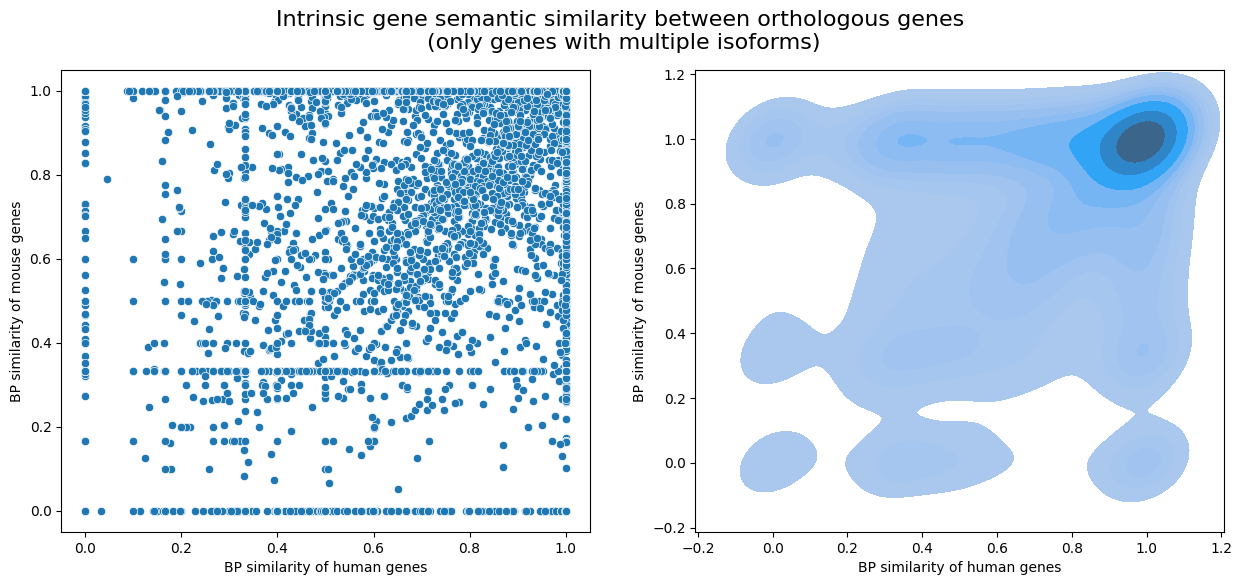

In [15]:
fig, ax =plt.subplots(1,2,figsize=(15, 6))
fig.suptitle('Intrinsic gene semantic similarity between orthologous genes \n(only genes with multiple isoforms)', fontsize=16)
sns.scatterplot(hm_orthologs[(hm_orthologs['ref niso'] >=2 ) & (hm_orthologs['other niso'] >=2)], x="ref semsim", y="other semsim",
                ax=ax[0])
ax[0].set(xlabel='BP similarity of human genes', ylabel='BP similarity of mouse genes')

sns.kdeplot(hm_orthologs[(hm_orthologs['ref niso'] >=2 ) & (hm_orthologs['other niso'] >=2)], x="ref semsim", y="other semsim", fill=True,
            ax=ax[1])
ax[1].set(xlabel='BP similarity of human genes', ylabel='BP similarity of mouse genes')

print(hm_orthologs[(hm_orthologs['ref niso'] >=2 ) & (hm_orthologs['other niso'] >=2)]['ref semsim'].corr(hm_orthologs[(hm_orthologs['ref niso'] >=2 ) & (hm_orthologs['other niso'] >=2)]['other semsim'],'spearman'))



0.4531227614507225


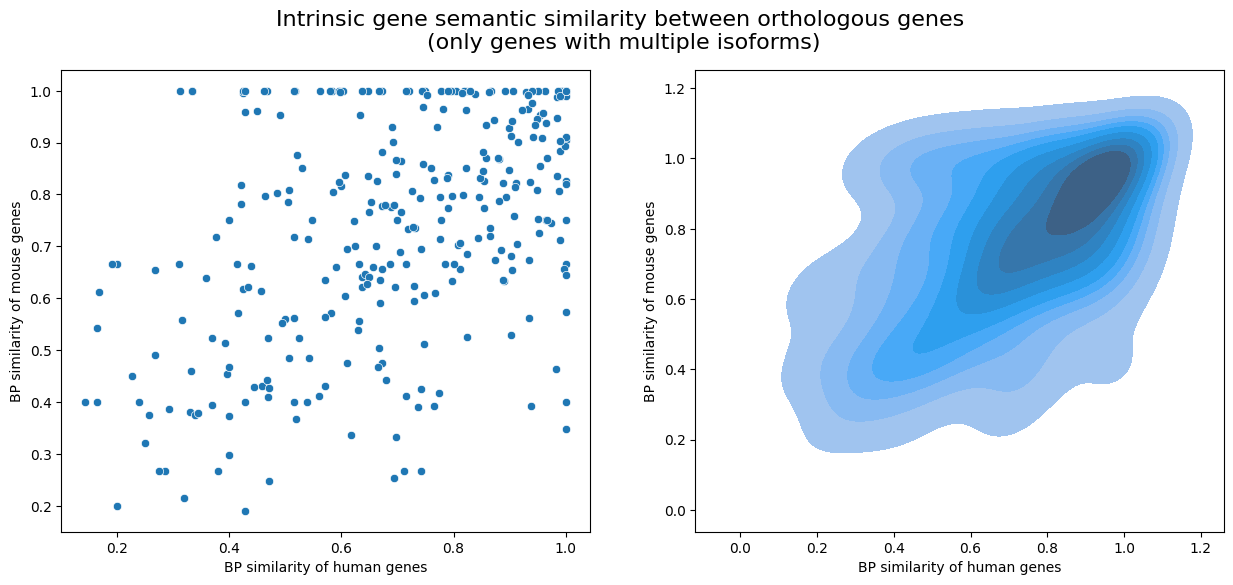

In [16]:
fig, ax =plt.subplots(1,2,figsize=(15, 6))
fig.suptitle('Intrinsic gene semantic similarity between orthologous genes \n(only genes with multiple isoforms)', fontsize=16)
sns.scatterplot(hm_orthologs[(hm_orthologs['ref niso'] >=6 ) & (hm_orthologs['other niso'] >=6)], x="ref semsim", y="other semsim",
                ax=ax[0])
ax[0].set(xlabel='BP similarity of human genes', ylabel='BP similarity of mouse genes')

sns.kdeplot(hm_orthologs[(hm_orthologs['ref niso'] >=6 ) & (hm_orthologs['other niso'] >=6)], x="ref semsim", y="other semsim", fill=True,
            ax=ax[1])
ax[1].set(xlabel='BP similarity of human genes', ylabel='BP similarity of mouse genes')

print(hm_orthologs[(hm_orthologs['ref niso'] >=6 ) & (hm_orthologs['other niso'] >=6)]['ref semsim'].corr(hm_orthologs[(hm_orthologs['ref niso'] >=6 ) & (hm_orthologs['other niso'] >=6)]['other semsim'],'spearman'))



## Semsim vs Protein len

In [19]:
human_df['Mean length'] = human_df["Gene"].apply(human_pannzer.get_gene).apply(gtga.Gene.mean_isoforms_length)
human_df

,Gene,Type,Number of isoform,Jaccard Index,Dice coefficient,Overlap coefficient,Redundance metric,Stdev number GO term,BP similarity,CC similarity,MF similarity,Mean length
0,ENSG00000292344,Observed,5,0.900000,0.942857,1.0,0.750000,1.20000,1.0,0.6000,1.0000,146.000
1,ENSG00000292358,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,517.000
2,ENSG00000292327,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,372.500
3,ENSG00000292354,Observed,2,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,259.500
4,ENSG00000292363,Observed,2,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,316.000
...,...,...,...,...,...,...,...,...,...,...,...,...
17582,ENSG00000008735,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,825.000
17583,ENSG00000100299,Observed,2,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,467.000
17584,ENSG00000251322,Observed,4,0.504464,0.508850,1.0,0.669643,144.19323,0.5,0.7935,0.5000,933.800
17585,ENSG00000100312,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,317.500


Text(0.5, 1.0, 'Mean length by number of isoform (human observed)')

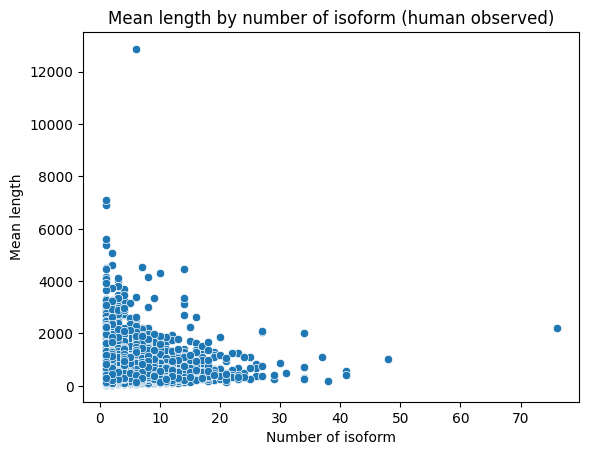

In [20]:
sns.scatterplot(human_df, x="Number of isoform", y="Mean length").set_title("Mean length by number of isoform (human observed)")

[Text(0.5, 0, 'BP similarity'), Text(0, 0.5, 'Mean length')]

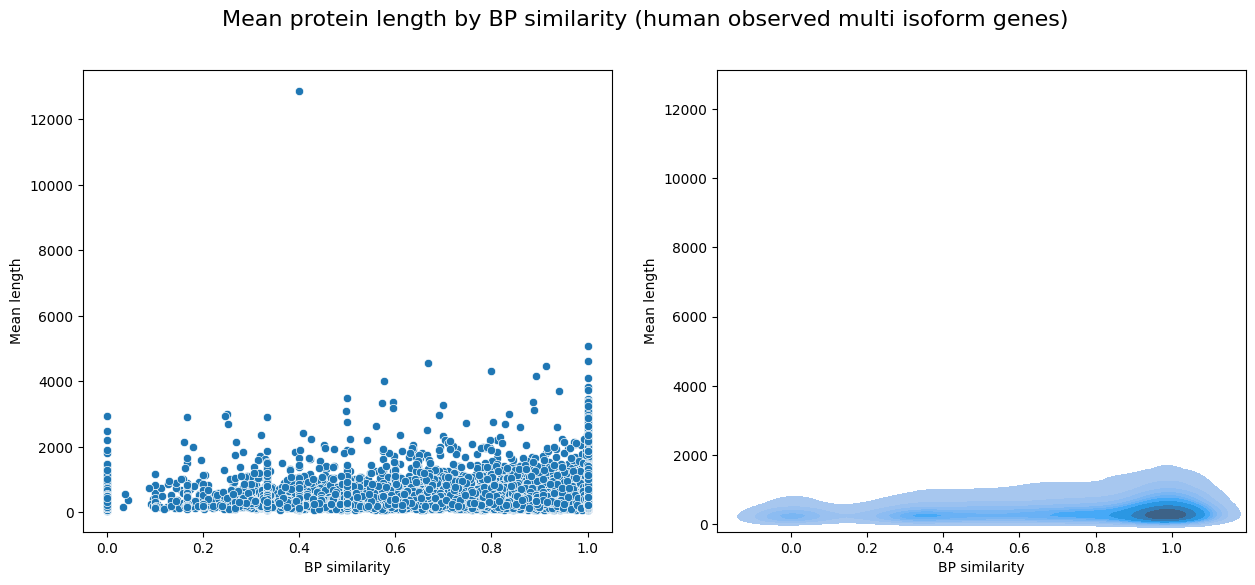

In [21]:
fig , ax  = plt.subplots(1,2,figsize=(15, 6))
fig.suptitle("Mean protein length by BP similarity (human observed multi isoform genes)", fontsize=16)
plot = sns.scatterplot(
    data = human_df[human_df["Number of isoform"] > 1],
    x = 'BP similarity',
    y = 'Mean length',
    ax=ax[0]
#    fill=True
)
ax[0].set(xlabel='BP similarity', ylabel='Mean length')
plot = sns.kdeplot(
    data = human_df[human_df["Number of isoform"] > 1],
    x = 'BP similarity',
    y = 'Mean length',
    ax=ax[1],
    fill=True)
ax[1].set(xlabel='BP similarity', ylabel='Mean length')

Text(0.5, 1.0, 'Mean protein length by BP similarity (human observed multi isoform genes)')

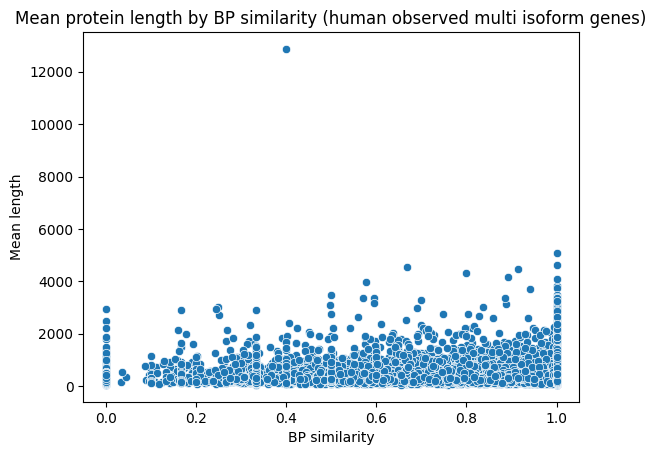

In [22]:
sns.scatterplot(human_df[human_df["Number of isoform"] > 1], x="BP similarity", y="Mean length").set_title("Mean protein length by BP similarity (human observed multi isoform genes)")

In [23]:
human_df[(human_df['BP similarity'] < 0.1) & (human_df['BP similarity'] > 0)]

,Gene,Type,Number of isoform,Jaccard Index,Dice coefficient,Overlap coefficient,Redundance metric,Stdev number GO term,BP similarity,CC similarity,MF similarity,Mean length
3491,ENSG00000138376,Observed,7,0.302925,0.379514,0.880952,0.233645,89.120876,0.095238,0.650333,0.404857,406.375000
3694,ENSG00000180902,Observed,5,0.497136,0.610955,0.990000,0.386905,14.499655,0.090200,0.098800,0.899100,236.000000
4656,ENSG00000161267,Observed,5,0.149008,0.226529,0.800000,0.144578,30.648980,0.033300,0.262400,0.492800,173.500000
4718,ENSG00000168826,Observed,3,0.065217,0.109091,0.333333,0.070866,31.647363,0.044333,0.333333,0.000000,361.666667
11081,ENSG00000111729,Observed,5,0.188237,0.250814,0.900000,0.193925,44.447722,0.095000,0.449900,0.449000,178.600000
14811,ENSG00000170832,Observed,6,0.312955,0.439484,0.995139,0.251613,19.541978,0.036933,0.191600,0.802133,545.666667
15937,ENSG00000272333,Observed,8,0.220784,0.319495,0.792895,0.159606,48.754327,0.087321,0.458143,0.450607,751.583333


In [24]:
for tr in human['ENSG00000010610'].transcripts.values():
    print(tr)
    print(tr.get_go_term_id())

Transcript 'ENST00000011653.9' with 288 GO terms
['GO:0015026', 'GO:0002250', 'GO:0009986', 'GO:0006955', 'GO:0038023', 'GO:0009897', 'GO:0002376', 'GO:0060089', 'GO:0045121', 'GO:0007155', 'GO:0023026', 'GO:0098857', 'GO:0023023', 'GO:0035397', 'GO:0005886', 'GO:0042012', 'GO:0045058', 'GO:0098552', 'GO:0042011', 'GO:0045657', 'GO:0005788', 'GO:0097011', 'GO:0042289', 'GO:0071944', 'GO:0097012', 'GO:0042287', 'GO:0005789', 'GO:0035723', 'GO:1990782', 'GO:0098827', 'GO:0071350', 'GO:0019955', 'GO:0042175', 'GO:0070672', 'GO:0019901', 'GO:0031984', 'GO:0046598', 'GO:0004896', 'GO:0005783', 'GO:0075294', 'GO:0140375', 'GO:0070013', 'GO:0045655', 'GO:0019900', 'GO:0043233', 'GO:1903902', 'GO:0044877', 'GO:0031974', 'GO:0046596', 'GO:0042803', 'GO:0012505', 'GO:0030225', 'GO:0042802', 'GO:0031090', 'GO:0052372', 'GO:0019899', 'GO:0016020', 'GO:0042110', 'GO:0005102', 'GO:0043231', 'GO:0043903', 'GO:0046983', 'GO:0043227', 'GO:0002763', 'GO:0004888', 'GO:0005737', 'GO:0046649', 'GO:0005515'

## Semsim vs exon number

In [25]:
annotation_human = pd.read_csv('../data/gencode.v45.human.protein_coding.no_readthrough.no_redundant_transcript.gff3', sep='\t', header=None)
annotation_human

,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,65419,71585,.,+,.,ID=ENSG00000186092.7;gene_id=ENSG00000186092.7...
1,chr1,HAVANA,transcript,65419,71585,.,+,.,ID=ENST00000641515.2;Parent=ENSG00000186092.7;...
2,chr1,HAVANA,exon,65419,65433,.,+,.,ID=exon:ENST00000641515.2:1;Parent=ENST0000064...
3,chr1,HAVANA,exon,65520,65573,.,+,.,ID=exon:ENST00000641515.2:2;Parent=ENST0000064...
4,chr1,HAVANA,CDS,65565,65573,.,+,0,ID=CDS:ENST00000641515.2;Parent=ENST0000064151...
...,...,...,...,...,...,...,...,...,...
1474595,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ID=CDS:ENST00000361681.2;Parent=ENST0000036168...
1474596,chrM,ENSEMBL,gene,14747,15887,.,+,.,ID=ENSG00000198727.2;gene_id=ENSG00000198727.2...
1474597,chrM,ENSEMBL,transcript,14747,15887,.,+,.,ID=ENST00000361789.2;Parent=ENSG00000198727.2;...
1474598,chrM,ENSEMBL,exon,14747,15887,.,+,.,ID=exon:ENST00000361789.2:1;Parent=ENST0000036...


In [26]:
annotation_exon_humain = annotation_human[annotation_human[2]=='exon']
annotation_exon_humain

,0,1,2,3,4,5,6,7,8
2,chr1,HAVANA,exon,65419,65433,.,+,.,ID=exon:ENST00000641515.2:1;Parent=ENST0000064...
3,chr1,HAVANA,exon,65520,65573,.,+,.,ID=exon:ENST00000641515.2:2;Parent=ENST0000064...
5,chr1,HAVANA,exon,69037,71585,.,+,.,ID=exon:ENST00000641515.2:3;Parent=ENST0000064...
9,chr1,HAVANA,exon,450740,451678,.,-,.,ID=exon:ENST00000426406.4:1;Parent=ENST0000042...
13,chr1,HAVANA,exon,685716,686654,.,-,.,ID=exon:ENST00000332831.5:1;Parent=ENST0000033...
...,...,...,...,...,...,...,...,...,...
1474582,chrM,ENSEMBL,exon,10470,10766,.,+,.,ID=exon:ENST00000361335.1:1;Parent=ENST0000036...
1474586,chrM,ENSEMBL,exon,10760,12137,.,+,.,ID=exon:ENST00000361381.2:1;Parent=ENST0000036...
1474590,chrM,ENSEMBL,exon,12337,14148,.,+,.,ID=exon:ENST00000361567.2:1;Parent=ENST0000036...
1474594,chrM,ENSEMBL,exon,14149,14673,.,-,.,ID=exon:ENST00000361681.2:1;Parent=ENST0000036...


In [27]:
def infogff2dict(x):
    return dict( (k,v) for k,v in [element.split('=') for element in x.split(';')])

In [28]:
gene2rawexonnb = dict()
for index, row in annotation_exon_humain.iterrows():
    gene = infogff2dict(row[8])['gene_id'].split('.')[0]
    if gene in gene2rawexonnb:
        gene2rawexonnb[gene] += 1
    else:
        gene2rawexonnb[gene] = 1

In [29]:
human_df['Raw Exon Nb'] = human_df["Gene"].apply(gene2rawexonnb.get)
human_df['Mean Nb Exon'] = human_df['Raw Exon Nb']/human_df['Number of isoform']

Text(0.5, 1.0, 'Mean nb exon by BP similarity (human observed multi isoform genes)')

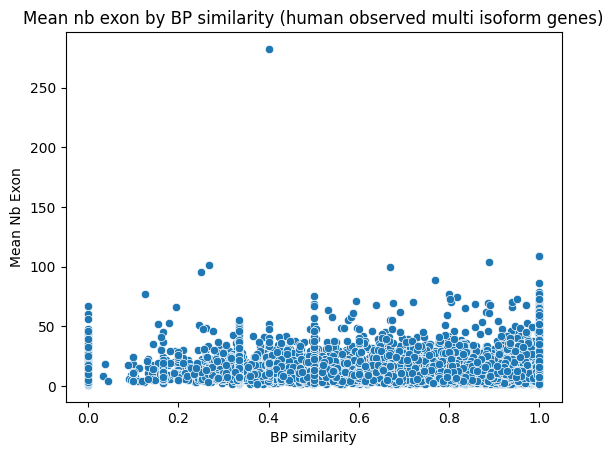

In [30]:
sns.scatterplot(human_df[human_df["Number of isoform"] > 1], x="BP similarity", y="Mean Nb Exon").set_title("Mean nb exon by BP similarity (human observed multi isoform genes)")

[Text(0.5, 0, 'BP similarity'), Text(0, 0.5, 'Mean Nb Exon')]

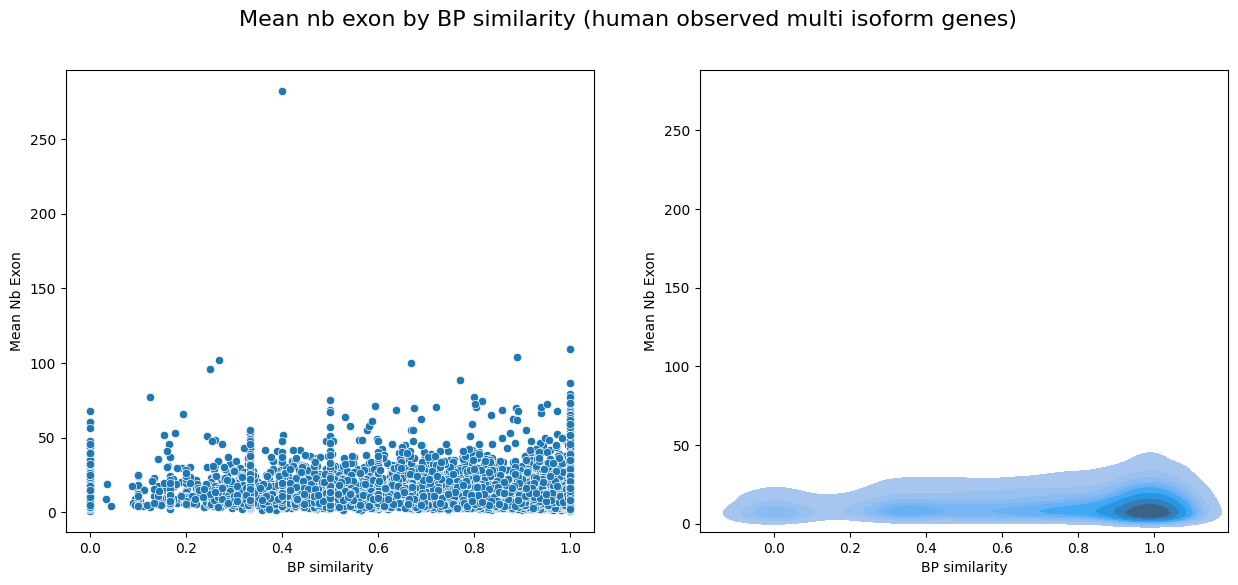

In [31]:
fig , ax  = plt.subplots(1,2,figsize=(15, 6))
fig.suptitle("Mean nb exon by BP similarity (human observed multi isoform genes)", fontsize=16)
plot = sns.scatterplot(
    data = human_df[human_df["Number of isoform"] > 1],
    x = 'BP similarity',
    y = 'Mean Nb Exon',
    ax=ax[0]
#    fill=True
)
ax[0].set(xlabel='BP similarity', ylabel='Mean Nb Exon')
plot = sns.kdeplot(
    data = human_df[human_df["Number of isoform"] > 1],
    x = 'BP similarity',
    y = 'Mean Nb Exon',
    ax=ax[1],
    fill=True)
ax[1].set(xlabel='BP similarity', ylabel='Mean Nb Exon')

In [32]:
human_df[(human_df['Mean Nb Exon'] > 120)]

,Gene,Type,Number of isoform,Jaccard Index,Dice coefficient,Overlap coefficient,Redundance metric,Stdev number GO term,BP similarity,CC similarity,MF similarity,Mean length,Raw Exon Nb,Mean Nb Exon
1013,ENSG00000142798,Observed,1,1.000000,1.000000,1.0,1.000000,0.0,1.0,1.0000,1.0,1066.000000,121,121.000000
1746,ENSG00000271425,Observed,1,1.000000,1.000000,1.0,1.000000,0.0,1.0,1.0000,1.0,1928.666667,202,202.000000
1765,ENSG00000271383,Observed,1,1.000000,1.000000,1.0,1.000000,0.0,1.0,1.0000,1.0,1341.500000,152,152.000000
2333,ENSG00000203710,Observed,1,1.000000,1.000000,1.0,1.000000,0.0,1.0,1.0000,1.0,1884.833333,217,217.000000
2483,ENSG00000143669,Observed,1,1.000000,1.000000,1.0,1.000000,0.0,1.0,1.0000,1.0,906.111111,136,136.000000
3006,ENSG00000174501,Observed,1,1.000000,1.000000,1.0,1.000000,0.0,1.0,1.0000,1.0,1050.250000,164,164.000000
3349,ENSG00000155657,Observed,6,0.917241,0.955556,1.0,0.917241,2.0,0.4,0.8914,1.0,12872.400000,1694,282.333333
3405,ENSG00000065413,Observed,1,1.000000,1.000000,1.0,1.000000,0.0,1.0,1.0000,1.0,637.875000,144,144.000000
3956,ENSG00000114270,Observed,1,1.000000,1.000000,1.0,1.000000,0.0,1.0,1.0000,1.0,1559.000000,128,128.000000
9204,ENSG00000048740,Observed,1,1.000000,1.000000,1.0,1.000000,0.0,1.0,1.0000,1.0,505.200000,137,137.000000


## Diversity Repartition

In [33]:
data_df = human_df[human_df['Number of isoform']!=1]
data_df

,Gene,Type,Number of isoform,Jaccard Index,Dice coefficient,Overlap coefficient,Redundance metric,Stdev number GO term,BP similarity,CC similarity,MF similarity,Mean length,Raw Exon Nb,Mean Nb Exon
0,ENSG00000292344,Observed,5,0.900000,0.942857,1.0,0.750000,1.200000,1.000000,0.600000,1.000000,146.000000,32,6.400000
3,ENSG00000292354,Observed,2,1.000000,1.000000,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,259.500000,12,6.000000
4,ENSG00000292363,Observed,2,1.000000,1.000000,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,316.000000,15,7.500000
5,ENSG00000292357,Observed,7,0.775286,0.854619,1.0,0.559028,9.448032,0.965238,0.838762,0.948857,315.250000,83,11.857143
6,ENSG00000292332,Observed,2,1.000000,1.000000,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,281.333333,27,13.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17578,ENSG00000177989,Observed,2,1.000000,1.000000,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,209.833333,32,16.000000
17580,ENSG00000205560,Observed,3,0.241698,0.303045,1.0,0.346154,36.971460,0.261333,0.746000,0.333333,545.666667,40,13.333333
17583,ENSG00000100299,Observed,2,1.000000,1.000000,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,467.000000,16,8.000000
17584,ENSG00000251322,Observed,4,0.504464,0.508850,1.0,0.669643,144.193230,0.500000,0.793500,0.500000,933.800000,54,13.500000


In [34]:
print(data_df['Jaccard Index'].mean())
print(sum(data_df['Jaccard Index']==1))
print(len(data_df))

0.6957575514712058
3042
11346


(0.0, 1000.0)

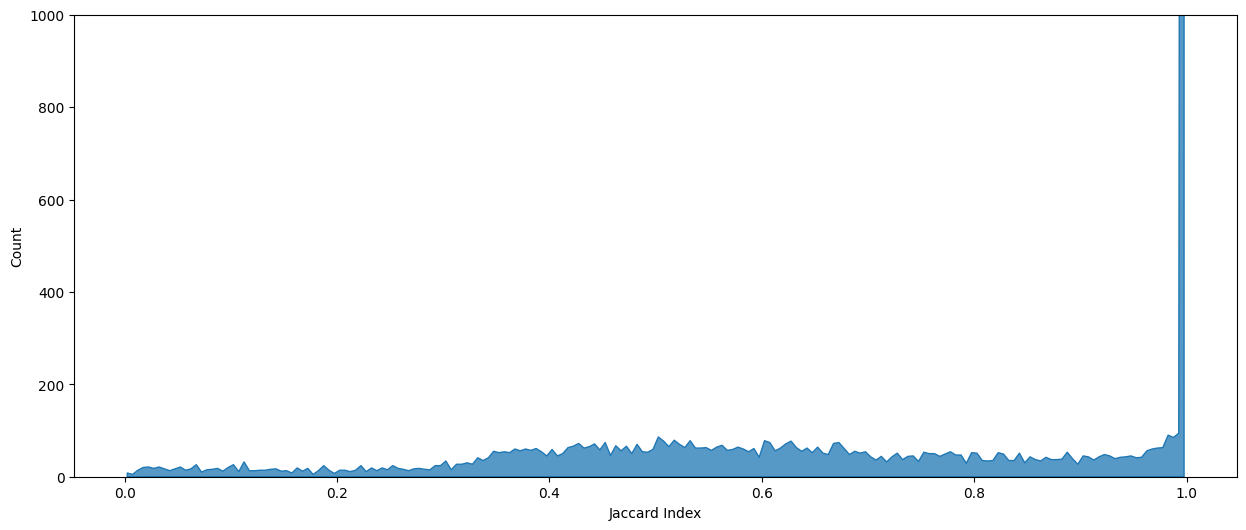

In [35]:
plt.figure(figsize=(15,6))
sns.histplot(human_df, x="Jaccard Index", element='poly', bins=200)
plt.ylim(0,1000)

## Entropy

In [36]:
human_df

,Gene,Type,Number of isoform,Jaccard Index,Dice coefficient,Overlap coefficient,Redundance metric,Stdev number GO term,BP similarity,CC similarity,MF similarity,Mean length,Raw Exon Nb,Mean Nb Exon
0,ENSG00000292344,Observed,5,0.900000,0.942857,1.0,0.750000,1.20000,1.0,0.6000,1.0000,146.000,32,6.4
1,ENSG00000292358,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,517.000,10,10.0
2,ENSG00000292327,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,372.500,16,16.0
3,ENSG00000292354,Observed,2,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,259.500,12,6.0
4,ENSG00000292363,Observed,2,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,316.000,15,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17582,ENSG00000008735,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,825.000,12,12.0
17583,ENSG00000100299,Observed,2,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,467.000,16,8.0
17584,ENSG00000251322,Observed,4,0.504464,0.508850,1.0,0.669643,144.19323,0.5,0.7935,0.5000,933.800,54,13.5
17585,ENSG00000100312,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,317.500,9,9.0


In [37]:
recount_df = pd.read_csv('../res/recount.tsv', sep='\t')
recount_df

,0,1,2
0,ENSG00000293560.1,ENST00000452010.2,52875
1,ENSG00000293560.1,ENST00000429079.1,78637
2,ENSG00000293559.1,ENST00000453194.2,1476
3,ENSG00000293558.1,ENST00000481772.3,44099
4,ENSG00000293557.1,ENST00000492965.5,32286
...,...,...,...
226832,ENSG00000000005.6,ENST00000485971.1,782150
226833,ENSG00000000005.6,ENST00000373031.5,178053
226834,ENSG00000000003.16,ENST00000612152.4,22492
226835,ENSG00000000003.16,ENST00000496771.5,292729


In [38]:
human_input = pd.read_csv('../data/human_input.tsv', sep='\t', header=None)
valid_transcript = human_input[1].tolist()

In [39]:
recount_df = recount_df[recount_df['1'].isin(valid_transcript)]

In [40]:
recount_df.columns = ['Gene','Transcript','Recount']
recount_df

,Gene,Transcript,Recount
28,ENSG00000293543.1,ENST00000707122.1,3423
31,ENSG00000293543.1,ENST00000372702.7,204362
1329,ENSG00000292373.1,ENST00000711287.1,0
1330,ENSG00000292373.1,ENST00000711286.1,0
1344,ENSG00000292372.1,ENST00000711272.1,0
...,...,...,...
226829,ENSG00000000419.14,ENST00000371588.10,17004778
226830,ENSG00000000419.14,ENST00000371584.9,623366
226831,ENSG00000000419.14,ENST00000371582.8,1423650
226833,ENSG00000000005.6,ENST00000373031.5,178053


In [41]:
def gene_entropy(raw):
    total = sum(raw)
    entropy = 0
    for val in raw:
        if val == 0:
            continue
        p = val/total
        ent = p*log2(1/p)
        entropy += ent
    return entropy

In [42]:
entropy_df = recount_df.groupby('Gene').aggregate(gene_entropy).reset_index()
entropy_df.columns = ['Gene', 'Entropy']
entropy_df['Gene'] = entropy_df['Gene'].apply(lambda x:x.split('.')[0])
entropy_df

/tmp/ipykernel_84029/208480992.py:1: FutureWarning: ['Transcript'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  entropy_df = recount_df.groupby('Gene').aggregate(gene_entropy).reset_index()


,Gene,Entropy
0,ENSG00000000003,0.000000
1,ENSG00000000005,0.000000
2,ENSG00000000419,0.601070
3,ENSG00000000457,0.675734
4,ENSG00000000460,1.521893
...,...,...
18301,ENSG00000292363,0.000000
18302,ENSG00000292366,0.000000
18303,ENSG00000292372,0.000000
18304,ENSG00000292373,0.000000


In [43]:
entropy_df = human_df.join(entropy_df.set_index('Gene'), on='Gene', how='left')
entropy_df

,Gene,Type,Number of isoform,Jaccard Index,Dice coefficient,Overlap coefficient,Redundance metric,Stdev number GO term,BP similarity,CC similarity,MF similarity,Mean length,Raw Exon Nb,Mean Nb Exon,Entropy
0,ENSG00000292344,Observed,5,0.900000,0.942857,1.0,0.750000,1.20000,1.0,0.6000,1.0000,146.000,32,6.4,0.000000
1,ENSG00000292358,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,517.000,10,10.0,0.000000
2,ENSG00000292327,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,372.500,16,16.0,0.000000
3,ENSG00000292354,Observed,2,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,259.500,12,6.0,0.000000
4,ENSG00000292363,Observed,2,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,316.000,15,7.5,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17582,ENSG00000008735,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,825.000,12,12.0,0.000000
17583,ENSG00000100299,Observed,2,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,467.000,16,8.0,0.406120
17584,ENSG00000251322,Observed,4,0.504464,0.508850,1.0,0.669643,144.19323,0.5,0.7935,0.5000,933.800,54,13.5,0.827181
17585,ENSG00000100312,Observed,1,1.000000,1.000000,1.0,1.000000,0.00000,1.0,1.0000,1.0000,317.500,9,9.0,0.162534


In [44]:
entropy_df[entropy_df['Number of isoform']==2]

,Gene,Type,Number of isoform,Jaccard Index,Dice coefficient,Overlap coefficient,Redundance metric,Stdev number GO term,BP similarity,CC similarity,MF similarity,Mean length,Raw Exon Nb,Mean Nb Exon,Entropy
3,ENSG00000292354,Observed,2,1.000000,1.000000,1.0,1.000000,0.0,1.000,1.0,1.000,259.500000,12,6.0,0.000000
4,ENSG00000292363,Observed,2,1.000000,1.000000,1.0,1.000000,0.0,1.000,1.0,1.000,316.000000,15,7.5,0.000000
6,ENSG00000292332,Observed,2,1.000000,1.000000,1.0,1.000000,0.0,1.000,1.0,1.000,281.333333,27,13.5,0.000000
9,ENSG00000292343,Observed,2,0.770833,0.870588,1.0,0.770833,5.5,0.868,1.0,0.796,571.500000,9,4.5,0.000000
11,ENSG00000292338,Observed,2,0.095238,0.173913,1.0,0.095238,9.5,0.000,0.0,0.751,177.000000,22,11.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17569,ENSG00000205593,Observed,2,0.263158,0.416667,1.0,0.263158,7.0,0.000,0.0,1.000,442.000000,30,15.0,0.829313
17574,ENSG00000100258,Observed,2,1.000000,1.000000,1.0,1.000000,0.0,1.000,1.0,1.000,695.500000,28,14.0,0.068124
17576,ENSG00000284194,Observed,2,1.000000,1.000000,1.0,1.000000,0.0,1.000,1.0,1.000,217.500000,4,2.0,0.338978
17578,ENSG00000177989,Observed,2,1.000000,1.000000,1.0,1.000000,0.0,1.000,1.0,1.000,209.833333,32,16.0,2.244127


<Axes: xlabel='Number of isoform', ylabel='Entropy'>

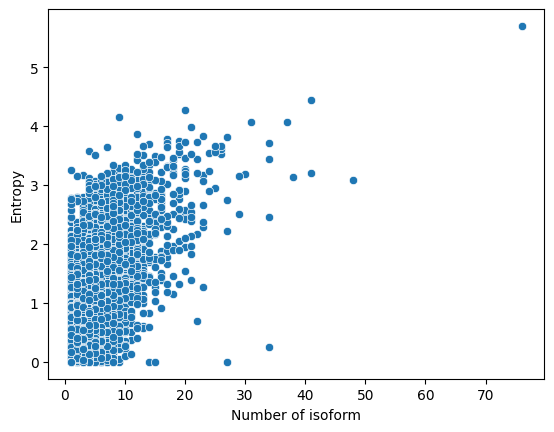

In [45]:
sns.scatterplot(entropy_df, x='Number of isoform', y='Entropy')

<Axes: xlabel='MF similarity', ylabel='Jaccard Index'>

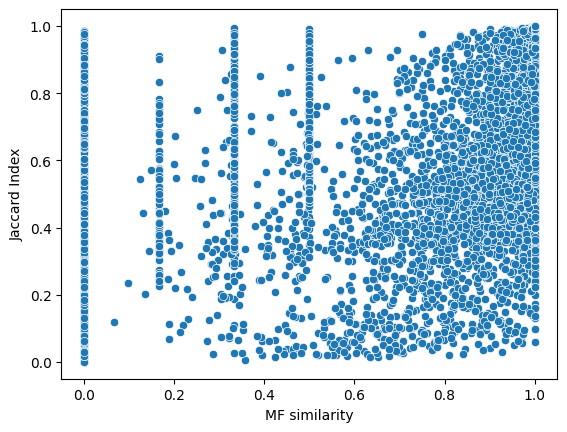

In [46]:
sns.scatterplot(entropy_df[entropy_df['Number of isoform']<5], x='MF similarity', y='Jaccard Index')